# **Introduction**

**Titile:Automatic Classification of Somali News Texts as Political or Non-Political**

##### Project Overview

This project aims to build an automatic classifier for Somali news articles, labeling them as either:

- `1` = Politics  
- `0` = Non-Politics

 **Dataset Summary**:
- Original articles: 3,316  
- After removing 308 duplicates → Final: **3,008 unique entries**

 **Models Used**:
- Traditional: BoW, TF-IDF, Word2Vec
- Deep Learning: CNN, RNN
- Transformers: mBERT, SomBERTa

The goal was to evaluate model performance on a **low-resource language** like Somali.


# **Step 1: Environment Setup & Dataset Loading**

In [ ]:
# =============================
# install & import packages
# =============================
!pip install -q wordcloud lightgbm openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
from collections import Counter
import gc
import re
import string
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#for drive access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Step 1:1 Dataset Loading and understanding***

In [ ]:
#load excel dataset from drive
df = pd.read_excel('/content/drive/MyDrive/Data-minig Indivitual project/Dataset/politacal_Binary_dataset.xlsx')

In [ ]:
#dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3316 entries, 0 to 3315
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  3316 non-null   object
 1   content   3316 non-null   object
dtypes: object(2)
memory usage: 51.9+ KB


In [ ]:
#category counts:
df['Category'].value_counts()

,count
Category,
politics,1945
non_politics,1371


**Class Distribution Summary**

The dataset includes **3,316 Somali news articles**:

-  Politics: 1,945 articles  
-  Non-Politics: 1,371 articles  

This shows a **moderate class imbalance**, with political articles more common.  
 This imbalance could affect model performance and may need handling through techniques like **resampling** or **class weighting**.


----

In [ ]:
#displaying first Few rows
df.head()D

,Category,content
0,politics,Jun 24 -Golaha Ammaanka ee Qaramada Midoobay a...
1,politics,Jun 24 -In ka badan 15 askari oo boolis ah iyo...
2,politics,Jun 23 -Koox hubeysan ayaa xalay saq-dhexedega...
3,politics,Jun 23 -Ugu yaraan 42 qof oo Falastiiniyiin ah...
4,politics,Jun 22 Ciidamada Israel ayaa duqeymo culus Jim...


***Step 1:2 Checking for Missing, Duplicates, and Data Types***

In [ ]:
# ===============================
# check for missing & duplicates
# ===============================

# Check for missing values
print("🔍 Missing Values:\n", df.isnull().sum())

🔍 Missing Values:
 Category    0
content     0
dtype: int64


**Missing Values Check**

There are **no missing values** in the `Category` or `content` columns.

This means the dataset is complete and ready for preprocessing and model training—no need for imputation or handling null entries.


In [ ]:
#check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"🔍 Duplicate Rows: {duplicate_count}")

🔍 Duplicate Rows: 308


In [ ]:
# drop duplicates if needed
df.drop_duplicates(inplace=True)

In [ ]:
# reset index after dropping
df.reset_index(drop=True, inplace=True)

# Recheck status
print("\n Cleaned Dataset Info:")
print(df.info(memory_usage='deep'))



 Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008 entries, 0 to 3007
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  3008 non-null   object
 1   content   3008 non-null   object
dtypes: object(2)
memory usage: 12.9 MB
None


**Duplicate Removal**

A total of **308 duplicate rows** were found and removed during data cleaning.

This step ensures the model trains on **unique and diverse examples**, reducing overfitting and improving generalization.


***Step 1:2 Assign Binary Labels***

In [ ]:
# apply label conversion
df['label'] = df['Category'].apply(lambda x: 1 if str(x).strip().lower() == 'politics' else 0)

# rename and keep only the necessary columns
df = df.rename(columns={'content': 'text'})[['text', 'label']]

In [ ]:
#displaying first Few Rows
df.head()

,text,label
0,Jun 24 -Golaha Ammaanka ee Qaramada Midoobay a...,1
1,Jun 24 -In ka badan 15 askari oo boolis ah iyo...,1
2,Jun 23 -Koox hubeysan ayaa xalay saq-dhexedega...,1
3,Jun 23 -Ugu yaraan 42 qof oo Falastiiniyiin ah...,1
4,Jun 22 Ciidamada Israel ayaa duqeymo culus Jim...,1


# **Step 2: Exploratory Data Visualization (EDA)**

***2.1 Class Distribution***

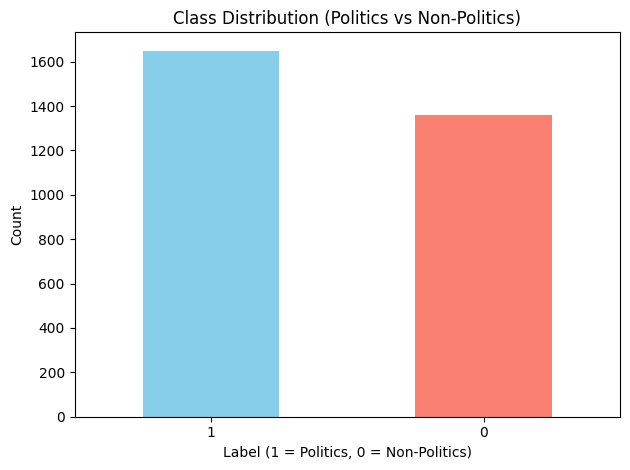

In [ ]:
# bar plot for label distribution
import matplotlib.pyplot as plt

def plot_class_distribution(labels):
    counts = labels.value_counts()
    counts.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title("Class Distribution (Politics vs Non-Politics)")
    plt.xlabel("Label (1 = Politics, 0 = Non-Politics)")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_class_distribution(df['label'])

**Class Distribution Interpretation**

The bar chart shows the label distribution:

-  **Label 1 (Politics)**: ~1,650+ articles  
-  **Label 0 (Non-Politics)**: ~1,350+ articles  

This reflects the **real-world dominance of political content** in Somali news sources.


***2.2 Text Length Distribution***

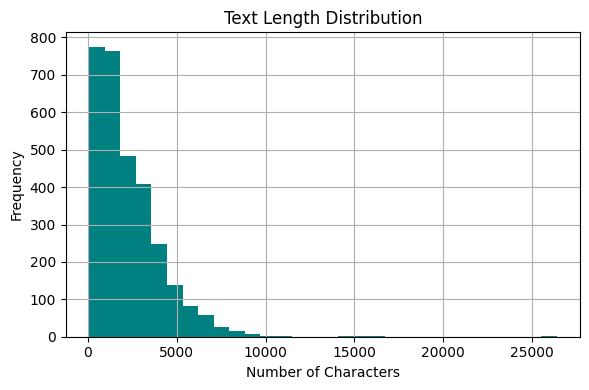

In [ ]:
# add column with text lengths
df['text_length'] = df['text'].astype(str).apply(len)

# plot histogram
plt.figure(figsize=(6, 4))
df['text_length'].hist(bins=30, color='teal')
plt.title("Text Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

**Text Length Distribution Interpretation**

The histogram shows article lengths (in characters):

-  Most articles are short — over **700** have fewer than **1,000 characters**.
-  A few articles exceed **10,000**, with only a couple near **25,000** characters.

 This suggests the dataset is mainly made up of **concise articles**, with a few long-form texts.


***2.3 Word Cloud (All Data)***

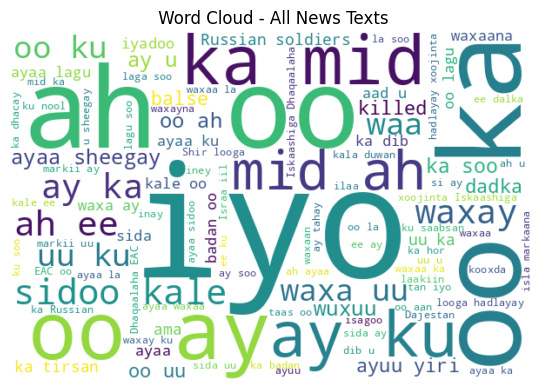

In [ ]:
from wordcloud import WordCloud

def plot_wordcloud(text_series, title='Word Cloud', max_words=100):
    text = ' '.join(text_series.dropna().tolist())
    wc = WordCloud(width=600, height=400, max_words=max_words, background_color='white').generate(text)
    plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_wordcloud(df['text'], title=" Word Cloud - All News Texts")

*** 2.4 Word Cloud by Class***

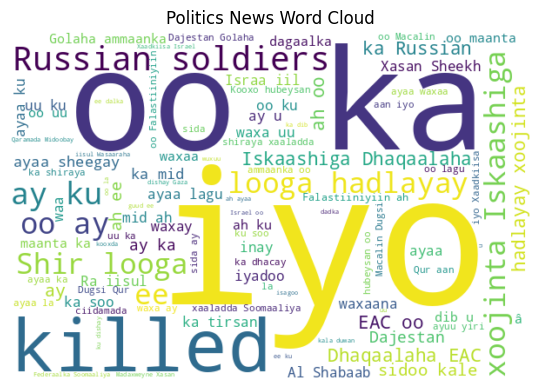

In [ ]:
#split by label
politics_texts = df[df['label'] == 1]['text']
plot_wordcloud(politics_texts, title="Politics News Word Cloud")

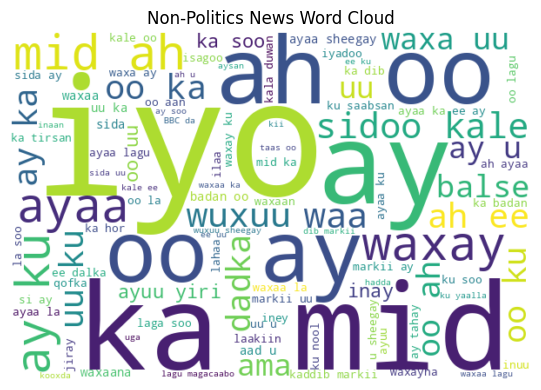

In [ ]:
non_politics_texts = df[df['label'] == 0]['text']
plot_wordcloud(non_politics_texts, title="Non-Politics News Word Cloud")

# **Step 3.0: Clean & Save Preprocessed Dataset as preprocessed_df**

In [ ]:
som_stopwords = set([
    'iyo', 'ka', 'oo', 'waxa', 'sida', 'taas', 'isla', 'kaas',
    'in', 'ayaa', 'ku', 'la', 'ma', 'dadka', 'weyn', 'qof', 'waxay', 'u', 'waa',
    'dhamaan', 'bilaash', 'haddii', 'halkii', 'sidaas', 'markii',
    'ama', 'wuxuu', 'uusan', 'halkaas', 'ah', 'tahay',
    'tan', 'hadda', 'ha', 'ugu', 'waana', 'balse', 'iyadoo', 'waan', 'laga',
    'isagoo', 'ah', 'ee', 'waxey', 'lasoo', 'ugu', 'uu', 'eeyga', 'loo', 'sii',
    'haddaba', 'loona', 'hadda', 'inkastoo', 'kula', 'waxuu', 'uga', 'soo',
    'si', 'kuu', 'kasoo', 'eey', 'aad', 'baan', 'leh', 'beey', 'ahna', 'yahay',
    'mana', 'waxaana', 'kaddib', 'dib', 'maxay', 'inay', 'inaan', 'inaana',
    'inaanay', 'inaaney', 'lakin', 'kale', 'inuu', 'hadana', 'dhan', 'ayuu',
    'aaney', 'ayee', 'kala', 'kule', 'sidoo', 'kalena', 'aysan', 'laakiin',
    'hor', 'ayay', 'kuwaas', 'wali', 'isku', 'halkaasoo', 'ay', 'kuna', 'aan',
    'markaana', 'ahaanba', 'kamid','muxuu', 'awgeed', 'miyuu', 'iska', 'kaliya',
    'markiiba', 'kuwo', 'kuwa','intaysan', 'wuxuuna', 'xitaa', 'kuwee', 'kuwaas',
    'kuwii','dabadeed', 'yihiin', 'gabi', 'iskaba', 'awgii', 'isugu',
    'kuwaasoo', 'kaddibna', 'waxba', 'usoo', 'lagama', 'wuu', 'lamana', 'naga',
    'loogu', 'aadka', 'kii', 'kana', 'idiin', 'inoo', 'aynu', 'yaa', 'iney',
    'waxaan', 'waxaa', 'waliba', 'kasta', 'ilaa', 'ahayd', 'waxana', 'ina',
    'inan', 'waxaas', 'maxaad', 'lagu', 'wixii', 'walba', 'ahayn', 'inaga',
    'ila', 'wada', 'una', 'xataa', 'walina', 'way', 'inaad', 'kama', 'ahaa',
    'lama', 'kaga', 'nagu', 'aay', 'ha', 'aaynu', 'uma', 'ayaad', 'kusoo',
    'aha', 'sidee', 'iskugu', 'kalana', 'kamida', 'hore', 'inkasta', 'iwm',
    'waxayna', 'hase', 'maxaan', 'ayaana', 'kahor', 'kadib', 'kaa', 'aheyn',
    'kugu', 'waxaanu', 'kan', 'ayey', 'kaasi', 'noo', 'iga', 'iigu', 'ayayna',
    'inuusan', 'baannu', 'looga', 'idin', 'kadibna', 'ahaatee', 'waaye',
    'nooga', 'isu', 'kaleba', 'maxaa', 'islamarkaana', 'lagala', 'kastaba',
    'naloo', 'walbo', 'kuma', 'is', 'mise', 'igu', 'lakiin', 'baa', 'yaan',
    'nagala', 'amase', 'haa', 'waxaad', 'idiinku', 'maxad', 'kasii', 'baad',
    'waxan', 'sidii', 'kuwaasi', 'iskeed', 'ula', 'nugul', 'horta', 'intiisa',
    'yeeshee', 'kusii', 'uugu', 'sideen', 'unbuu', 'looguna', 'inaanu',
    'markuu', 'bal', 'mooyee', 'hadduu', 'midba', 'wuxu', 'waayo', 'iima',
    'iimaanu', 'waxsoo', 'caadiga', 'innoo', 'aanad', 'lala', 'amma', 'waad',
    'kuugu', 'hadii', 'markaa', 'hasii', 'lee', 'anaan', 'ii', 'tankale',
    'weeyaan', 'waase', 'isoo', 'haatan', 'haddana', 'waxaanay', 'hadaan',
    'ayna', 'uuna', 'inaysan', 'aya', 'laguna', 'laguma', 'ta', 'inaa', 'lkn',
    'haku', 'hasoo', 'waayahay', 'kulasoo', 'sidaas', 'tahay', 'mid',
    'marka', 'markii', 'marki', 'een', 'mr', 'ayo', 'isu', 'taasi',
    'nta', 'uun', 'sidii', 'mar', 'ke', 'jira', 'jirtey', 'jeer',
    'labada', 'waayey', 'manta', 'maanta', 'mida', 'shalay', 'jirta'
])

***Step: 3:1 Somali-Aware Text Normalization & Preprocessed Output***

### Somali Text Cleaning Summary

To improve data quality for Somali NLP, we applied the following cleaning steps:

-  **Allowed only Somali letters**: a–z (excluding P, V, Z), digits (0–9), and basic punctuation (, . ! ? ( ) - ')
- **Removed**:
  - URLs (http, https, www)
  - Emails (e.g., test@mail.com)
  - HTML tags (e.g., <div>, <a>)
  - Corrupted chars (�)
  - Emojis and symbols (😊 ✈️ ⚽)

This ensures the text is clean, readable, and Somali-specific — ideal for training models.


In [ ]:
# somali latin alphabet (no P, V, Z)
SOMALI_ALPHABET = (
    "aA" "bB" "cC" "dD" "eE" "fF" "gG" "hH" "iI" "jJ" "kK" "lL" "mM" "nN"
    "oO" "qQ" "rR" "sS" "tT" "uU" "wW" "xX" "yY"
)

# allowed characters for somali
ALLOWED_CHARS = SOMALI_ALPHABET + "0123456789 ,.!?()-'"

# compile regex patterns for cleaning unwanted content from Somali text

# matches URLs like http://..., https://..., www...
url_pattern = re.compile(r"http\S+|www\S+|https\S+")

# matches email addresses like someone@example.com
email_pattern = re.compile(r"\S+@\S+")

# matches any HTML tags such as <div>, <p>, <a href=...> etc.
html_pattern = re.compile(r"<.*?>")

# Matches corrupted or replacement characters like � often seen in scraped text
weird_char_pattern = re.compile(r"[�]")

# Matches a wide range of emojis and pictographs using Unicode ranges
emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # Emoticons (smileys, expressions)
    u"\U0001F300-\U0001F5FF"  # Misc Symbols & Pictographs
    u"\U0001F680-\U0001F6FF"  # Transport & Map Symbols
    u"\U0001F700-\U0001F77F"  # Alchemical Symbols
    u"\U0001F780-\U0001F7FF"  # Geometric Symbols
    u"\U0001F800-\U0001F8FF"  # Supplemental Arrows & other symbols
    u"\U0001F900-\U0001F9FF"  # Supplemental Symbols & Pictographs
    u"\U0001FA00-\U0001FA6F"  # Extended Symbols (e.g. Chess)
    u"\U0001FA70-\U0001FAFF"  # Symbols & Pictographs Extended-A
    u"\U00002702-\U000027B0"  # Dingbats (✂, ✈, ✉, etc.)
    u"\U000024C2-\U0001F251"  # Enclosed characters
    "]+", flags=re.UNICODE)


In [ ]:
# function to normalize and clean somali text
def normalize_somali_text(text):
    # convert to string and normalize unicode
    text = unicodedata.normalize("NFKD", str(text))
    text = ''.join([char for char in text if not unicodedata.combining(char)])  # Remove accents

    # lowercase
    text = text.lower()

    # remove URLs, emails, HTML, emojis, and weird characters
    text = url_pattern.sub(" ", text)
    text = email_pattern.sub(" ", text)
    text = html_pattern.sub(" ", text)
    text = emoji_pattern.sub(" ", text)
    text = weird_char_pattern.sub(" ", text)

    # keep only allowed Somali characters
    text = ''.join([char for char in text if char in ALLOWED_CHARS.lower()])

    # normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # tokenize
    tokens = text.split()

    # remove short words, digits, and STOPWORDS
    tokens = [
        t for t in tokens
        if len(t) > 2 and not any(char.isdigit() for char in t) and t not in som_stopwords
    ]

    return tokens

***Step:3:2 Apply Normalization, Analyze Vocab, and Save to preprocessed_df***

In [ ]:
#apply tokenization to all rows
tokenized_words = df["text"].apply(normalize_somali_text)

In [ ]:
# flatten all tokens into one list
all_words = [word for row in tokenized_words for word in row]

#sount word frequency
word_freq = Counter(all_words)

# show vocabulary stats
print("Total words (including repeats):", len(all_words))
print("Total unique words:", len(word_freq))
print("Top 10 most frequent words:", word_freq.most_common(10))

Total words (including repeats): 601942
Total unique words: 85752
Top 10 most frequent words: [('sheegay', 4815), ('badan', 4267), ('wax', 2875), ('dalka', 2565), ('soomaaliya', 2187), ('ah.', 2155), ('ah,', 2097), ('dowladda', 1721), ('magaalada', 1597), ('sheegtay', 1561)]


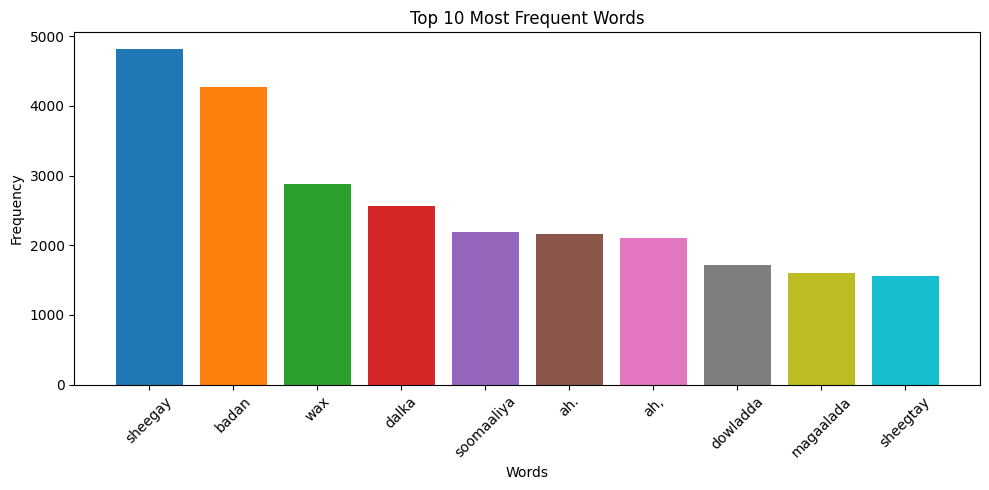

In [ ]:
#top N words to display
top_n = 10
top_words = word_freq.most_common(top_n)

#separate words and counts
words, counts = zip(*top_words)

#generating a list of different colors to display diffrent as color.
colors = plt.cm.tab10.colors  # we can also try: 'tab10', 'Set3', 'Pastel1', etc.
color_list = [colors[i % len(colors)] for i in range(top_n)]

# Plot
plt.figure(figsize=(10, 5))
plt.bar(words, counts, color=color_list)
plt.title(f"Top {top_n} Most Frequent Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Interpretation of the Top 10 Most Frequent Words

The bar chart shows the 10 most common words in the Somali news dataset:

- **Frequent words include**: `sheegay` (said), `badan` (many/much), `wax` (thing), `dalka` (the country), and `soomaaliya` (Somalia).
- **Other common terms**: `ah`, `ah,`, and `magalada` (the city).
- **Variation**: Words like `sheegay` and `sheegtay` show gender or verb form differences in Somali.


***Step:3:3 Finaly Save cleaned and preproccessed as preprocessed_df***

In [ ]:
#save to preprocessed_df
preprocessed_df = pd.DataFrame({
    'text': tokenized_words.apply(lambda tokens: ' '.join(tokens)),  # Joining tokens back into string
    'label': df['label']
})

***Step:3:4  Save to File for Later Use***

In [ ]:
#save to google drive (Excel or CSV)
preprocessed_df.to_csv("/content/drive/MyDrive/Data-minig Indivitual project/prerpcessing saved/preprocessed_somali_news.csv", index=False)

**Saving Preprocessed Data to Google Drive**

To prevent data loss from RAM crashes or Colab resets, the cleaned dataset (with text and labels) was saved to **Google Drive**.

This backup ensures:
- No need to repeat preprocessing steps.
- Quick recovery and consistent access for training and evaluation.
- Smooth workflow even if the Colab session disconnects.

This is a best practice for cloud-based projects.


----

In [ ]:
#load excel dataset from drive
cleaned_df = pd.read_csv('/content/drive/MyDrive/Data-minig Indivitual project/prerpcessing saved/preprocessed_somali_news.csv')

***loaded on new Dataframe to use it again.***

# **Step 4: Feature Extraction**

## ***Step: 4.1 Text Split***

***I will split dataset to use as Train and test..***

In [ ]:
from sklearn.model_selection import train_test_split

# step 1: split cleaned text and labels into train and test sets
X_train_text, X_test_text, y_train, y_test = train_test_split(
    cleaned_df["text"],  # use cleaned text column
    cleaned_df["label"],  # use label column
    test_size=0.2,        # 20% for testing
    random_state=42       # ensure same split each time
)

***preparing and applaying for bow and TFIDF to use the next models..***

***Step: 4.1.1 Apply both vectorizers to the cleaned text***

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# define vectorizers
bow_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

# use Bag of Words (BoW) to convert text to count vectors
X_train_bow = bow_vectorizer.fit_transform(X_train_text)
X_test_bow = bow_vectorizer.transform(X_test_text)

# use TF-IDF to convert text to weighted vectors
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

## ***Step:4.3 Prepare Data for Deep Learning (CNN/RNN)***

In [ ]:
import numpy as np

#convert sparse matrix to dense
X_train_bow_dl = np.expand_dims(X_train_bow.toarray().astype("float32"), axis=2)
X_test_bow_dl = np.expand_dims(X_test_bow.toarray().astype("float32"), axis=2)

X_train_tfidf_dl = np.expand_dims(X_train_tfidf.toarray().astype("float32"), axis=2)
X_test_tfidf_dl = np.expand_dims(X_test_tfidf.toarray().astype("float32"), axis=2)

***i will use below fucntion for displayin any result of the models.***

## ***Step: 4.3 Unified Evaluation Function***

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, X, y, model_name="Model", dataset_name="Test", keras=False, threshold=0.5, return_metrics=False):
    # predict
    if keras:
        y_pred_probs = model.predict(X)
        if y_pred_probs.shape[-1] == 1:
            y_pred = (y_pred_probs > threshold).astype("int").flatten()
        else:
            y_pred = np.argmax(y_pred_probs, axis=1)
    else:
        y_pred = model.predict(X)

    # compute metrics
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y, y_pred, average="weighted", zero_division=0)

    # print results
    print(f"\nEvaluation: {model_name} on {dataset_name} set")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(classification_report(y, y_pred, zero_division=0))

    # plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - {dataset_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # optionally return metrics
    if return_metrics:
        return {
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1,
            "y_true": y,
            "y_pred": y_pred,
            "confusion_matrix": cm
        }

## ***Step:4.4 Prepare and Train MLP***

In [ ]:
from sklearn.neural_network import MLPClassifier

# MLP with BoW
mlp_bow = MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, random_state=42)
mlp_bow.fit(X_train_bow, y_train)

# MLP with TF-IDF
mlp_tfidf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, random_state=42)
mlp_tfidf.fit(X_train_tfidf, y_train)

MLPClassifier(random_state=42)

***Step:4.4.1 Prepare and Train MLP with bow***


Evaluation: MLP with BoW on Train set
Accuracy : 0.9946
Precision: 0.9946
Recall   : 0.9946
F1-Score : 0.9946
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1100
           1       1.00      0.99      1.00      1306

    accuracy                           0.99      2406
   macro avg       0.99      0.99      0.99      2406
weighted avg       0.99      0.99      0.99      2406



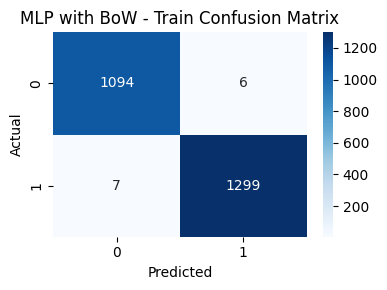

In [ ]:
# MLP
# evaluate on training set
evaluate_model(mlp_bow, X_train_bow, y_train, model_name="MLP with BoW", dataset_name="Train")

**MLP + BoW (Training Set) – Performance Summary**

The MLP model using **Bag of Words (BoW)** showed excellent results on the training data:

- **Accuracy, Precision, Recall, F1-Score**: ~**0.9946**

**Confusion Matrix**:
-  Only **13 misclassifications** out of **2,406 samples**
- Class 0 → **1,094 correct**, **6 wrong**
- Class 1 → **1,299 correct**, **7 wrong**

This shows the model fits the training data **very well**.  
 However, testing on unseen data is essential to rule out **overfitting**.



Evaluation: MLP with BoW on Test set
Accuracy : 0.9684
Precision: 0.9685
Recall   : 0.9684
F1-Score : 0.9685
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       258
           1       0.98      0.97      0.97       344

    accuracy                           0.97       602
   macro avg       0.97      0.97      0.97       602
weighted avg       0.97      0.97      0.97       602



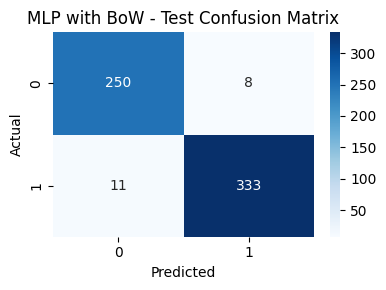

In [ ]:
# evaluate on test set
evaluate_model(mlp_bow, X_test_bow, y_test, model_name="MLP with BoW", dataset_name="Test")

**MLP + BoW (Test Set) – Generalization Performance**

The MLP model using **Bag of Words** achieved strong results on the test set:

- **Accuracy**: 96.84%
- **Precision, Recall, F1-Score**: ~96.8–97%

**Confusion Matrix**:
- Class 0 → ✅ 250 correct, ❌ 8 wrong
- Class 1 → ✅ 333 correct, ❌ 11 wrong

These results indicate **high generalization** with **minimal misclassifications**, making the model reliable for Somali news classification.


***Step:4.4.2 Prepare and Train MLP with tf-idf***


Evaluation: MLP with TF-IDF on Train set
Accuracy : 0.9946
Precision: 0.9946
Recall   : 0.9946
F1-Score : 0.9946
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1100
           1       0.99      1.00      1.00      1306

    accuracy                           0.99      2406
   macro avg       0.99      0.99      0.99      2406
weighted avg       0.99      0.99      0.99      2406



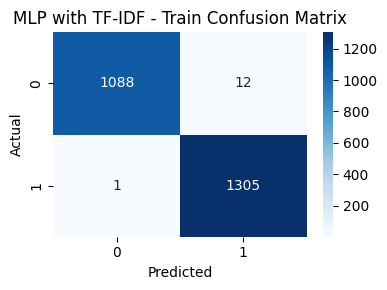

In [ ]:
# evaluate on training set
evaluate_model(mlp_tfidf, X_train_tfidf, y_train, model_name="MLP with TF-IDF", dataset_name="Train")

**MLP + TF-IDF (Training Set) – Performance** Summary

The MLP model using **TF-IDF** achieved excellent results on the training data:

- **Accuracy, Precision, Recall, F1-Score**: 0.9946

**Confusion Matrix**:
- Class 0 (Non-Politics) → ✅ 1,088 correct, ❌ 12 wrong
- Class 1 (Politics) → ✅ 1,305 correct, ❌ 1 wrong

Only **13 misclassifications** out of **2,406 samples**

This shows **strong and balanced learning** across both classes.  
Test evaluation is still needed to check for possible **overfitting**.



Evaluation: MLP with TF-IDF on Test set
Accuracy : 0.9668
Precision: 0.9672
Recall   : 0.9668
F1-Score : 0.9668
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       258
           1       0.98      0.96      0.97       344

    accuracy                           0.97       602
   macro avg       0.96      0.97      0.97       602
weighted avg       0.97      0.97      0.97       602



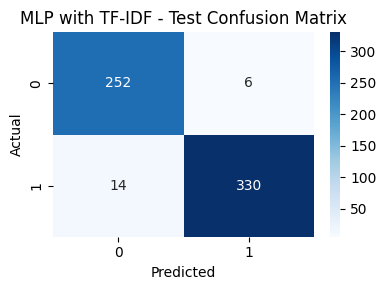

In [ ]:
# evaluate on test set
evaluate_model(mlp_tfidf, X_test_tfidf, y_test, model_name="MLP with TF-IDF", dataset_name="Test")

**MLP + TF-IDF (Test Set) – Generalization Performance**

The MLP model with **TF-IDF** performed strongly on the test data:

- **Accuracy**: 96.68%  
- **Precision**: 96.72%  
- **Recall**: 96.68%  
- **F1-Score**: 96.68%

**Confusion Matrix**:
- Class 0 (Non-Politics) → ✅ 252 correct, ❌ 6 wrong  
- Class 1 (Politics) → ✅ 330 correct, ❌ 14 wrong

The model shows **strong and balanced performance** on both classes with **minimal errors**, confirming its effectiveness for Somali news classification.


### ***Step:4.4.3 Prepare and Train LGBM***

In [ ]:
from lightgbm import LGBMClassifier
# LGBM with BoW
X_train_bow = X_train_bow.astype('float32')
X_test_bow = X_test_bow.astype('float32')
lgbm_bow = LGBMClassifier()
lgbm_bow.fit(X_train_bow, y_train)

# LGBM with TF-IDF
X_train_tfidf = X_train_tfidf.astype('float32')
X_test_tfidf = X_test_tfidf.astype('float32')
lgbm_tfidf = LGBMClassifier()
lgbm_tfidf.fit(X_train_tfidf, y_train)


[LightGBM] [Info] Number of positive: 1306, number of negative: 1100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13005
[LightGBM] [Info] Number of data points in the train set: 2406, number of used features: 3109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542810 -> initscore=0.171659
[LightGBM] [Info] Start training from score 0.171659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1306, number of negative: 1100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80287
[LightGBM] [Info] Number of data points

LGBMClassifier()

***Step:4.4.4 Prepare and Train LGBM with bow***


Evaluation: LGBM with BoW on Train set
Accuracy : 0.9946
Precision: 0.9946
Recall   : 0.9946
F1-Score : 0.9946
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1100
           1       1.00      0.99      1.00      1306

    accuracy                           0.99      2406
   macro avg       0.99      0.99      0.99      2406
weighted avg       0.99      0.99      0.99      2406



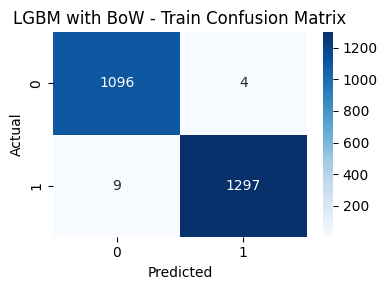

In [ ]:
# LGBM
# evaluate on training set on bow
evaluate_model(lgbm_bow, X_train_bow, y_train, model_name="LGBM with BoW", dataset_name="Train")

**LGBM + BoW (Training Set) – Performance Summary**

The LightGBM model using **Bag of Words (BoW)** achieved excellent performance on the training set:

- **Accuracy**: 0.9946  
- **Precision**: 0.9946  
- **Recall**: 0.9946  
- **F1-Score**: 0.9946

**Confusion Matrix**:
- Class 0 (Non-Politics) → ✅ 1,096 correct, ❌ 4 wrong  
- Class 1 (Politics) → ✅ 1,297 correct, ❌ 9 wrong  
- **Total samples**: 2,406 → Only **13 misclassifications**

These results show the model fits the training data **very well** with **balanced precision and recall**, indicating strong learning performance.


Evaluation: LGBM with BoW on Test set
Accuracy : 0.9801
Precision: 0.9803
Recall   : 0.9801
F1-Score : 0.9801
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       258
           1       0.99      0.97      0.98       344

    accuracy                           0.98       602
   macro avg       0.98      0.98      0.98       602
weighted avg       0.98      0.98      0.98       602



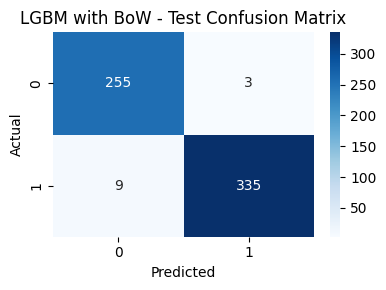

In [ ]:
# evaluate on test set on bow
evaluate_model(lgbm_bow, X_test_bow, y_test, model_name="LGBM with BoW", dataset_name="Test")

**LGBM + BoW (Test Set) – Generalization Performance**

The LightGBM model with **Bag of Words** showed strong performance on the test set:

- **Accuracy**: 98.01%  
- **Precision**: 98.03%  
- **Recall**: 98.01%  
- **F1-Score**: 98.01%

**Confusion Matrix**:
- Class 0 (Non-Politics) → ✅ 255 correct, ❌ 3 wrong  
- Class 1 (Politics) → ✅ 335 correct, ❌ 9 wrong  
- **Total samples**: 602 → Only **12 misclassifications**

The model generalizes **very well** with high scores and minimal errors across both classes, making it reliable for real-world Somali news classification.


***Step:4.4.5 Prepare and Train LGBM with tf-idf***


Evaluation: LGBM with TF-IDF on Train set
Accuracy : 0.9946
Precision: 0.9946
Recall   : 0.9946
F1-Score : 0.9946
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1100
           1       1.00      0.99      1.00      1306

    accuracy                           0.99      2406
   macro avg       0.99      0.99      0.99      2406
weighted avg       0.99      0.99      0.99      2406



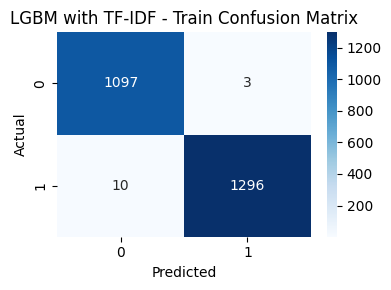

In [ ]:
# evaluate on training set on tfidf
evaluate_model(lgbm_tfidf, X_train_tfidf, y_train, model_name="LGBM with TF-IDF", dataset_name="Train")

**LGBM + TF-IDF (Training Set) – Performance Summary**

The LightGBM model using **TF-IDF** features achieved excellent performance on the training data:

- **Accuracy**: 0.9946  
- **Precision**: 0.9946  
- **Recall**: 0.9946  
- **F1-Score**: 0.9946

**Confusion Matrix**:
- Class 0 (Non-Politics) → ✅ 1,097 correct, ❌ 3 wrong  
- Class 1 (Politics) → ✅ 1,296 correct, ❌ 10 wrong  
- **Total samples**: 2,406 → Only **13 misclassifications**

These results show very **strong and balanced learning**, similar to LGBM with BoW, and indicate high model confidence on the training set.



Evaluation: LGBM with TF-IDF on Test set
Accuracy : 0.9834
Precision: 0.9838
Recall   : 0.9834
F1-Score : 0.9834
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       258
           1       1.00      0.97      0.99       344

    accuracy                           0.98       602
   macro avg       0.98      0.98      0.98       602
weighted avg       0.98      0.98      0.98       602



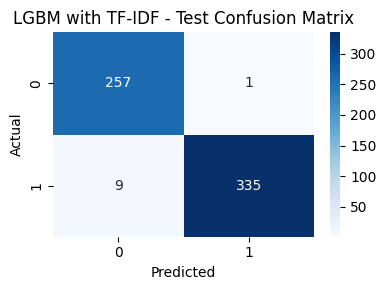

In [ ]:
# evaluate on test set on tfidf
evaluate_model(lgbm_tfidf, X_test_tfidf, y_test, model_name="LGBM with TF-IDF", dataset_name="Test")

**LGBM + TF-IDF (Test Set) – Generalization Performance**

The LightGBM model with **TF-IDF** features performed exceptionally well on the test data:

- **Accuracy**: 98.34%  
- **Precision**: 98.38%  
- **Recall**: 98.34%  
- **F1-Score**: 98.34%

**Confusion Matrix**:
- Class 0 (Non-Politics) → ✅ 257 correct, ❌ 1 wrong  
- Class 1 (Politics) → ✅ 335 correct, ❌ 9 wrong  
- **Total samples**: 602 → Only **10 misclassifications**

The model shows **excellent generalization**, accurately handling both classes with very few errors, making it a highly reliable choice for Somali news classification.


## **CNN and RNN without W2V(BOW and TF-IDF)**

----

## ***Step:4.5 Prepare and Train CNN***

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM

# CNN with BoW
cnn_bow = Sequential([
    Conv1D(128, 5, activation='relu', input_shape=X_train_bow_dl.shape[1:]),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
cnn_bow.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_bow.fit(X_train_bow_dl, y_train, epochs=5, batch_size=64, validation_data=(X_test_bow_dl, y_test))

***Step:4.5.1 Prepare and Train CNN with bow***

76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step

Evaluation: CNN with BoW on Train set
Accuracy : 0.9942
Precision: 0.9942
Recall   : 0.9942
F1-Score : 0.9942
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1100
           1       0.99      1.00      0.99      1306

    accuracy                           0.99      2406
   macro avg       0.99      0.99      0.99      2406
weighted avg       0.99      0.99      0.99      2406



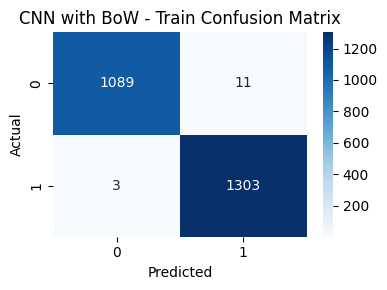

In [ ]:
# CNN (BoW)
evaluate_model(cnn_bow, X_train_bow_dl, y_train, model_name="CNN with BoW", dataset_name="Train", keras=True)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step

Evaluation: CNN with BoW on Test set
Accuracy : 0.9651
Precision: 0.9665
Recall   : 0.9651
F1-Score : 0.9652
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       258
           1       0.99      0.95      0.97       344

    accuracy                           0.97       602
   macro avg       0.96      0.97      0.96       602
weighted avg       0.97      0.97      0.97       602



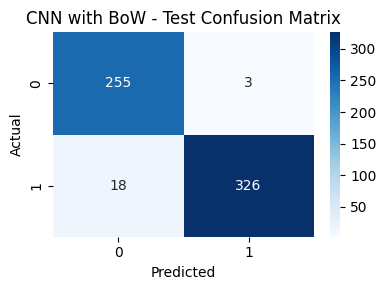

In [ ]:
evaluate_model(cnn_bow, X_test_bow_dl, y_test, model_name="CNN with BoW", dataset_name="Test", keras=True)

**CNN + BoW – Performance Summary**

The CNN model trained with **Bag of Words (BoW)** features shows consistently strong results:

#### Training Set:
- **Accuracy**: 99.42%
- Class 0 (Non-Politics) → ✅ 1,089 correct, ❌ 11 wrong  
- Class 1 (Politics) → ✅ 1,303 correct, ❌ 3 wrong  

#### Test Set:
- **Accuracy**: 96.51%
- Class 0 (Non-Politics) → ✅ 255 correct, ❌ 3 wrong  
- Class 1 (Politics) → ✅ 326 correct, ❌ 18 wrong  

---

### Summary:
The model performs **exceptionally well** on the training data and **generalizes effectively** on unseen data with minimal performance drop.  
It maintains high **precision and recall** across both classes.

Slightly higher misclassifications for political articles in the test set suggest possible room for tuning.  
Still, **CNN + BoW is a strong and reliable model** for Somali news classification.


### ***Step:4.5.2 Prepare and Train CNN with tf-idf***

In [ ]:
# CNN with TF-IDF
cnn_tfidf = Sequential([
    Conv1D(128, 5, activation='relu', input_shape=X_train_tfidf_dl.shape[1:]),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
cnn_tfidf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_tfidf.fit(X_train_tfidf_dl, y_train, epochs=5, batch_size=64, validation_data=(X_test_tfidf_dl, y_test))


Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 53s 962ms/step - accuracy: 0.7623 - loss: 0.5009 - val_accuracy: 0.9485 - val_loss: 0.1362
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 425ms/step - accuracy: 0.9781 - loss: 0.0763 - val_accuracy: 0.9585 - val_loss: 0.0952
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 432ms/step - accuracy: 0.9896 - loss: 0.0301 - val_accuracy: 0.9551 - val_loss: 0.1248
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - accuracy: 0.9944 - loss: 0.0187 - val_accuracy: 0.9601 - val_loss: 0.0967
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 429ms/step - accuracy: 0.9956 - loss: 0.0161 - val_accuracy: 0.9601 - val_loss: 0.0961


76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step

Evaluation: CNN with TF-IDF on Train set
Accuracy : 0.9946
Precision: 0.9946
Recall   : 0.9946
F1-Score : 0.9946
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1100
           1       1.00      0.99      1.00      1306

    accuracy                           0.99      2406
   macro avg       0.99      0.99      0.99      2406
weighted avg       0.99      0.99      0.99      2406



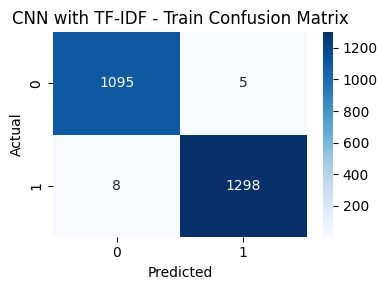

In [ ]:
# CNN (TF-IDF)
# evaluate on training set
evaluate_model(cnn_tfidf, X_train_tfidf_dl, y_train, model_name="CNN with TF-IDF", dataset_name="Train", keras=True)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

Evaluation: CNN with TF-IDF on Test set
Accuracy : 0.9601
Precision: 0.9606
Recall   : 0.9601
F1-Score : 0.9602
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       258
           1       0.98      0.95      0.96       344

    accuracy                           0.96       602
   macro avg       0.96      0.96      0.96       602
weighted avg       0.96      0.96      0.96       602



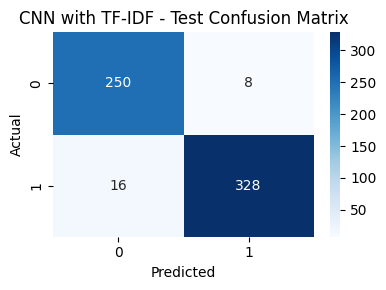

In [ ]:
# evaluate on training set
evaluate_model(cnn_tfidf, X_test_tfidf_dl, y_test, model_name="CNN with TF-IDF", dataset_name="Test", keras=True)

**CNN + TF-IDF – Performance Summary**

The CNN model using **TF-IDF features** performed exceptionally well on both training and test sets.

---

#### Training Set:
- **Accuracy, Precision, Recall, F1-Score**: 99.46%
- Confusion Matrix:
  - Class 0 → ✅ 1,095 correct, ❌ 5 wrong  
  - Class 1 → ✅ 1,298 correct, ❌ 8 wrong  
Very few misclassifications, showing excellent learning across both classes.

---

####  Test Set:
- **Accuracy**: 96.01%  
- **Precision**: 96.06%  
- **Recall**: 96.01%  
- **F1-Score**: 96.02%
- Confusion Matrix:
  - Class 0 → ✅ 250 correct, ❌ 8 wrong  
  - Class 1 → ✅ 328 correct, ❌ 16 wrong  

Slight increase in errors compared to training, but still **well within acceptable limits**.

---

### Conclusion:
CNN with **TF-IDF** is a **high-performing and balanced** model for Somali news classification.  
It achieves strong accuracy and recall on both training and test data with **minimal overfitting**.


***Step:4.5.3 Prepare and Train RNN***

In [ ]:
# RNN with BoW
rnn_bow = Sequential([
    LSTM(64, input_shape=X_train_bow_dl.shape[1:]),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
rnn_bow.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn_bow.fit(X_train_bow_dl, y_train, epochs=5, batch_size=64, validation_data=(X_test_bow_dl, y_test))

Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.4864 - loss: 0.6925 - val_accuracy: 0.5731 - val_loss: 0.6821
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.5407 - loss: 0.6913 - val_accuracy: 0.5748 - val_loss: 0.6840
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.5501 - loss: 0.6874 - val_accuracy: 0.4286 - val_loss: 1.2034
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.4915 - loss: 0.8475 - val_accuracy: 0.5714 - val_loss: 0.6874
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.5399 - loss: 0.6945 - val_accuracy: 0.5714 - val_loss: 0.6865


### ***Step:4.5.4 Prepare and Train RNN with bow***

76/76 ━━━━━━━━━━━━━━━━━━━━ 44s 577ms/step

Evaluation: RNN with BoW on Train set
Accuracy : 0.5428
Precision: 0.2946
Recall   : 0.5428
F1-Score : 0.3820
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1100
           1       0.54      1.00      0.70      1306

    accuracy                           0.54      2406
   macro avg       0.27      0.50      0.35      2406
weighted avg       0.29      0.54      0.38      2406



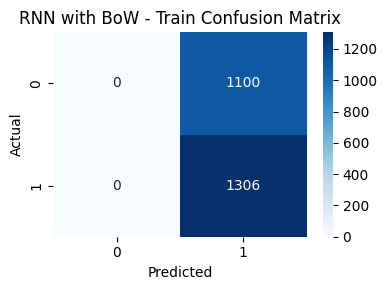

In [ ]:
# RNN (BoW)
evaluate_model(rnn_bow, X_train_bow_dl, y_train, model_name="RNN with BoW", dataset_name="Train", keras=True)

19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 558ms/step

Evaluation: RNN with BoW on Test set
Accuracy : 0.5714
Precision: 0.3265
Recall   : 0.5714
F1-Score : 0.4156
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       258
           1       0.57      1.00      0.73       344

    accuracy                           0.57       602
   macro avg       0.29      0.50      0.36       602
weighted avg       0.33      0.57      0.42       602



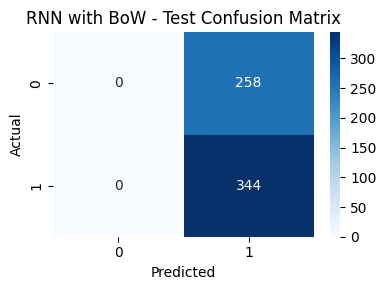

In [ ]:
evaluate_model(rnn_bow, X_test_bow_dl, y_test, model_name="RNN with BoW", dataset_name="Test", keras=True)

### ***Step:4.5.5 Prepare and Train RNN***

**RNN + BoW – Performance Overview**

The RNN model using **Bag of Words (BoW)** struggled to learn meaningful patterns, showing poor performance on both training and test sets.

---

#### Training Set:
- **Accuracy**: 54.28%  
- **Precision**: 29.46%  
- **Recall**: 54.28%  
- **F1-Score**: 38.20%

**Confusion Matrix**:
- Class 0 (Non-Politics) → ❌ 1,100 misclassified  
- Class 1 (Politics) → ✅ 1,306 correct  
The model predicted **only class 1** for all inputs.

---

#### Test Set:
- **Accuracy**: 57.14%  
- **Precision**: 32.65%  
- **Recall**: 57.14%  
- **F1-Score**: 41.56%

**Confusion Matrix**:
- Class 0 (Non-Politics) → ❌ 258 misclassified  
- Class 1 (Politics) → ✅ 344 correct  
Again, the model predicted **only class 1**, ignoring the other class.

---

### Conclusion:
RNN with BoW **fails to distinguish between the two classes**, always predicting class 1. This results in:

- **Zero recall** for non-political articles (class 0)
- **Major imbalance** in prediction
- **Ineffective generalization**

Recommendation: Consider using **Word2Vec** or **TF-IDF embeddings** with RNN, or switching to CNNs or transformer-based models for better performance.


In [ ]:
# RNN with TF-IDF
rnn_tfidf = Sequential([
    LSTM(64, input_shape=X_train_tfidf_dl.shape[1:]),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
rnn_tfidf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn_tfidf.fit(X_train_tfidf_dl, y_train, epochs=5, batch_size=64, validation_data=(X_test_tfidf_dl, y_test))

Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.5211 - loss: 0.6927 - val_accuracy: 0.5714 - val_loss: 0.6880
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.5379 - loss: 0.6905 - val_accuracy: 0.5714 - val_loss: 0.6845
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.5495 - loss: 0.6884 - val_accuracy: 0.5714 - val_loss: 0.6866
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5560 - loss: 0.6876 - val_accuracy: 0.5714 - val_loss: 0.6852
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5467 - loss: 0.6889 - val_accuracy: 0.5714 - val_loss: 0.6851


***Step:4.5.6 Prepare and Train RNN with tf-idf***

76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 749ms/step

Evaluation: RNN with TF-IDF on Train set
Accuracy : 0.5428
Precision: 0.2946
Recall   : 0.5428
F1-Score : 0.3820
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1100
           1       0.54      1.00      0.70      1306

    accuracy                           0.54      2406
   macro avg       0.27      0.50      0.35      2406
weighted avg       0.29      0.54      0.38      2406



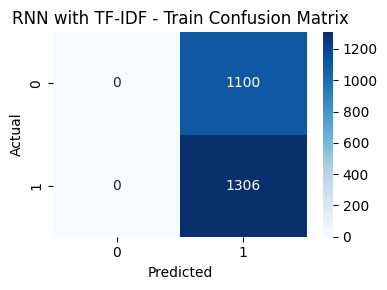

In [ ]:
# RNN (TF-IDF)
evaluate_model(rnn_tfidf, X_train_tfidf_dl, y_train, model_name="RNN with TF-IDF", dataset_name="Train", keras=True)

19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 588ms/step

Evaluation: RNN with TF-IDF on Test set
Accuracy : 0.5714
Precision: 0.3265
Recall   : 0.5714
F1-Score : 0.4156
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       258
           1       0.57      1.00      0.73       344

    accuracy                           0.57       602
   macro avg       0.29      0.50      0.36       602
weighted avg       0.33      0.57      0.42       602



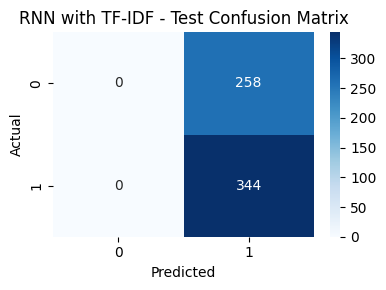

In [ ]:
evaluate_model(rnn_tfidf, X_test_tfidf_dl, y_test, model_name="RNN with TF-IDF", dataset_name="Test", keras=True)

**Overall Summary: RNN with BoW and TF-IDF**

The **RNN models trained with BoW and TF-IDF** features performed poorly compared to other models.

---

#### Major Observations:

- Both models **predicted only the majority class** (`label 1 = Politics`) for **all samples**.
- The confusion matrices confirm that **no instances of the minority class** (`label 0 = Non-Politics`) were correctly predicted.
- Despite showing **accuracy around 54–57%**, this is **misleading** since one class was entirely ignored.
- **Precision for class 0 was 0.00**, and **macro averages** were very low, reflecting the models' failure to handle class imbalance.

**Conclusion**: RNNs combined with sparse features like BoW and TF-IDF are **not suitable** for this classification task without additional techniques (e.g., better embeddings or class rebalancing).


---

## ***Step:4.6 Load Word2Vec model***

In [ ]:
#!pip install --force-reinstall --no-cache-dir numpy pandas gensim nltk

In [ ]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM

In [ ]:
# step 2: define parameters
sequence_length = 50  # number of tokens per sample
w2v_path = "/content/drive/MyDrive/Data-minig Indivitual project/W2V model/SomaliWors2Vec_MDS231_v1.2.model"

# step 3: tokenize raw text
X_train_tokens = [text_to_word_sequence(text) for text in X_train_text]
X_test_tokens = [text_to_word_sequence(text) for text in X_test_text]

# step 4: load trained word2Vec model
w2v_model = Word2Vec.load(w2v_path)
vector_size = w2v_model.vector_size

In [ ]:
# step 5: convert tokens to word2Vec embedding vectors
def tokens_to_vectors(tokens, model):
    return [model.wv[word] for word in tokens if word in model.wv]

X_train_seq = [tokens_to_vectors(tokens, w2v_model) for tokens in X_train_tokens]
X_test_seq = [tokens_to_vectors(tokens, w2v_model) for tokens in X_test_tokens]

# step 6: pad/truncate to fixed sequence length
X_train_w2v = pad_sequences(X_train_seq, maxlen=sequence_length, dtype='float32', padding='post', truncating='post')
X_test_w2v = pad_sequences(X_test_seq, maxlen=sequence_length, dtype='float32', padding='post', truncating='post')

### ***Step:4.6.1 CNN with Word2Vec model***

In [ ]:
# CNN with Word2Vec
cnn_w2v = Sequential([
    Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train_w2v.shape[1], X_train_w2v.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
cnn_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_w2v.fit(X_train_w2v, y_train, epochs=5, batch_size=64, validation_data=(X_test_w2v, y_test))


Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7635 - loss: 0.4639 - val_accuracy: 0.9136 - val_loss: 0.2063
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9035 - loss: 0.2250 - val_accuracy: 0.9203 - val_loss: 0.1711
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9373 - loss: 0.1454 - val_accuracy: 0.9302 - val_loss: 0.1608
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9546 - loss: 0.1095 - val_accuracy: 0.9336 - val_loss: 0.1505
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9610 - loss: 0.0922 - val_accuracy: 0.9302 - val_loss: 0.1522


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Evaluation: CNN with Word2Vec on Train set
Accuracy : 0.9863
Precision: 0.9864
Recall   : 0.9863
F1-Score : 0.9863
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1100
           1       0.98      1.00      0.99      1306

    accuracy                           0.99      2406
   macro avg       0.99      0.99      0.99      2406
weighted avg       0.99      0.99      0.99      2406



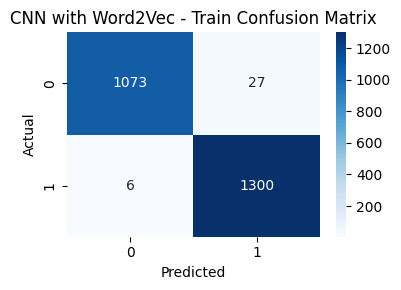

In [ ]:
# CNN (Word2Vec)
evaluate_model(cnn_w2v, X_train_w2v, y_train, model_name="CNN with Word2Vec", dataset_name="Train", keras=True)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Evaluation: CNN with Word2Vec on Test set
Accuracy : 0.9302
Precision: 0.9302
Recall   : 0.9302
F1-Score : 0.9302
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       258
           1       0.94      0.94      0.94       344

    accuracy                           0.93       602
   macro avg       0.93      0.93      0.93       602
weighted avg       0.93      0.93      0.93       602



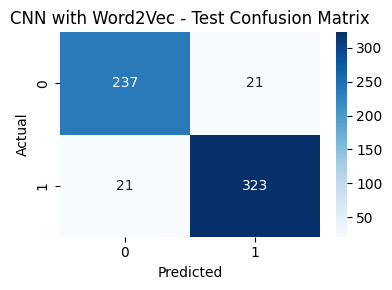

In [ ]:
evaluate_model(cnn_w2v, X_test_w2v, y_test, model_name="CNN with Word2Vec", dataset_name="Test", keras=True)

**CNN + Word2Vec – Performance Summary**

The CNN model with **Word2Vec embeddings** demonstrates strong and balanced performance across both training and test sets.

---

#### Training Set:
- **Accuracy**: 98.63%  
- **Precision / Recall / F1-Score**: 0.9863

**Confusion Matrix**:
- Class 0 (Non-Politics) → ✅ 1,073 correct, ❌ 27 wrong  
- Class 1 (Politics) → ✅ 1,300 correct, ❌ 6 wrong  
Excellent learning and class balance.

---

#### Test Set:
- **Accuracy**: 93.02%  
- **Precision / Recall / F1-Score**: 0.9302

 **Confusion Matrix**:
- Class 0 → ✅ 237 correct, ❌ 21 wrong  
- Class 1 → ✅ 323 correct, ❌ 21 wrong  
Generalizes well with a **small performance drop**.

---

###Summary:
CNN with **Word2Vec** captures **semantic relationships** effectively, leading to **high and stable performance**.  
It **outperforms RNNs** and performs **on par with TF-IDF CNNs**, making it a **strong choice** for Somali news classification where understanding word context is essential.


### ***Step:4.6.2 RNN with Word2Vec model***

In [ ]:
rnn_w2v = Sequential([
    LSTM(128, input_shape=(sequence_length, vector_size), return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
rnn_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

rnn_w2v.fit(X_train_w2v, y_train, epochs=5, batch_size=64, validation_data=(X_test_w2v, y_test))

Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 215ms/step - accuracy: 0.7204 - loss: 0.4974 - val_accuracy: 0.9136 - val_loss: 0.2334
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.8998 - loss: 0.2271 - val_accuracy: 0.9169 - val_loss: 0.1894
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9288 - loss: 0.1640 - val_accuracy: 0.9169 - val_loss: 0.2088
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.9325 - loss: 0.1498 - val_accuracy: 0.9236 - val_loss: 0.1681
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.9340 - loss: 0.1609 - val_accuracy: 0.9319 - val_loss: 0.1706


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

Evaluation: RNN with Word2Vec on Train set
Accuracy : 0.9343
Precision: 0.9382
Recall   : 0.9343
F1-Score : 0.9345
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1100
           1       0.98      0.90      0.94      1306

    accuracy                           0.93      2406
   macro avg       0.93      0.94      0.93      2406
weighted avg       0.94      0.93      0.93      2406



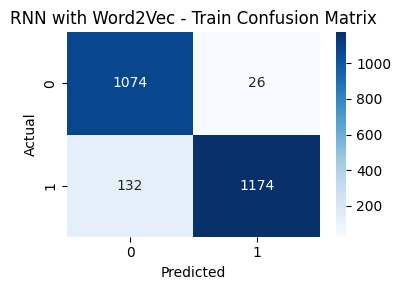

In [ ]:
#evaluating RNN Model
evaluate_model(rnn_w2v, X_train_w2v, y_train, model_name="RNN with Word2Vec", dataset_name="Train", keras=True)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

Evaluation: RNN with Word2Vec on Test set
Accuracy : 0.9319
Precision: 0.9357
Recall   : 0.9319
F1-Score : 0.9322
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       258
           1       0.97      0.90      0.94       344

    accuracy                           0.93       602
   macro avg       0.93      0.94      0.93       602
weighted avg       0.94      0.93      0.93       602



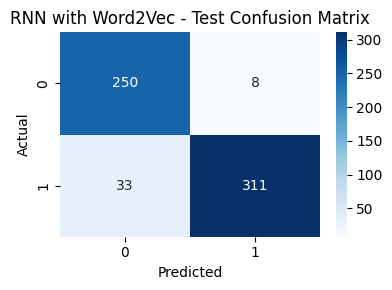

In [ ]:
#evaluating RNN Model
evaluate_model(rnn_w2v, X_test_w2v, y_test, model_name="RNN with Word2Vec", dataset_name="Test", keras=True)

**RNN + Word2Vec – Performance Summary**

The RNN model using **Word2Vec embeddings** performs **significantly better** than with BoW or TF-IDF, showing strong results on both training and test sets.

---

####Training Set:
- **Accuracy**: 93.43%  
- **Precision**: 93.82%  
- **Recall**: 93.43%  
- **F1-Score**: 93.45%

**Confusion Matrix**:
- Class 0 (Non-Politics) → ✅ 1,074 correct, ❌ 26 wrong  
- Class 1 (Politics) → ✅ 1,174 correct, ❌ 132 wrong

---

#### Test Set:
- **Accuracy**: 93.19%  
- **Precision**: 93.57%  
- **Recall**: 93.19%  
- **F1-Score**: 93.22%

 **Confusion Matrix**:
- Class 0 → ✅ 250 correct, ❌ 8 wrong  
- Class 1 → ✅ 311 correct, ❌ 33 wrong

---

### Summary:
RNN with **Word2Vec** performs **far better than BoW or TF-IDF**, capturing semantic meaning from text effectively.

- Maintains **high accuracy and F1-score**
- Performs **almost as well as CNN** but with slightly more misclassifications
- A solid model for sequential data, but performance could be improved by using **Bidirectional RNNs** or **more hyperparameter tuning**


# **Step:5:0 Test Large Language Models (LLMs): mBERT, SomBERTa**

In [ ]:
llm_df = pd.read_excel('/content/drive/MyDrive/Data-minig Indivitual project/Dataset/politacal_Binary_dataset.xlsx')

In [ ]:
llm_df.content[0]

'Jun 24 -Golaha Ammaanka ee Qaramada Midoobay ayaa maanta gelinka dambe ka shiraya xaaladaha dalka Soomaaliya. 15 Russian soldiers were killed in Dajestan 15 Askari oo ka tirsan ciidamadda Ruushka oo lagu dilay… Kulankaan oo lagu gorfeyn doono xaaladihii ugu dambeeyay ee Soomaaliya ayaa dhacaya shanta galabnimo xilliga Soomaaliya waxaana lagu wadaa in uu halkaa hadal ka jeediyo ku-simaha Ergeyga Gaarka ah ee Qaramada Midoobay James Swan.Sidoo kale mas’uuliyiin kale ayaa lagu wadaa in ay halkaa ka hadlaan. Si qoto dheer looma faahfaahin qodobbada sida gaarka ah looga hadli doono shirka, hase-yeeshee waxaan la fahamsanyahay in xaaladaha guud ee dalku marayo lagu soo qaadi doono kulanka.'

### **Cleansing and fine-tuning...**

In [ ]:
import re
import unicodedata

# Somali alphabet
SOMALI_ALPHABET = (
    "aA" "bB" "cC" "dD" "eE" "fF" "gG" "hH" "iI" "jJ" "kK" "lL" "mM" "nN"
    "oO" "qQ" "rR" "sS" "tT" "uU" "wW" "xX" "yY"
)

ALLOWED_CHARS = SOMALI_ALPHABET + "0123456789 ,.!?()-'"  # Numbers and standard punctuation

def preprocessor(text):
    text = unicodedata.normalize("NFKD", text)  # Normalize text to NFKD form to handle accented characters and other unicode variations
    text = ''.join([char for char in text if not unicodedata.combining(char)])  # Remove diacritics (accents) while keeping Somali alphabet characters
    text = text.lower()  # Lowercase the text (useful for BERT pretraining)
    text = ''.join([char for char in text if char in ALLOWED_CHARS.lower()])  # Remove unwanted characters based on ALLOWED_CHARS
    text = re.sub(r'([,.!?()-])\1+', r'\1', text)  # Replace multiple consecutive punctuation marks with a single occurrence
    text = re.sub(r'\s+', ' ', text).strip()  # Replace multiple spaces with a single space and trim leading/trailing spaces
    return text


In [ ]:
llm_df.columns

Index(['Category', 'content'], dtype='object')

In [ ]:
llm_df['content']  = llm_df['content'].fillna('').apply(preprocessor)

print("content field has been cleaned")

content field has been cleaned


In [ ]:
llm_df.content[0]

'jun 24 -golaha ammaanka ee qaramada midoobay ayaa maanta gelinka dambe ka shiraya xaaladaha dalka soomaaliya. 15 russian soldiers were killed in dajestan 15 askari oo ka tirsan ciidamadda ruushka oo lagu dilay. kulankaan oo lagu gorfeyn doono xaaladihii ugu dambeeyay ee soomaaliya ayaa dhacaya shanta galabnimo xilliga soomaaliya waxaana lagu wadaa in uu halkaa hadal ka jeediyo ku-simaha ergeyga gaarka ah ee qaramada midoobay james swan.sidoo kale masuuliyiin kale ayaa lagu wadaa in ay halkaa ka hadlaan. si qoto dheer looma faahfaahin qodobbada sida gaarka ah looga hadli doono shirka, hase-yeeshee waxaan la fahamsanyahay in xaaladaha guud ee dalku marayo lagu soo qaadi doono kulanka.'

### **Train-test split**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Method for splitting data into training and evaluation sets
def perform_train_test_split(X, y, test_size=0.2, stratify=None, random_state=42, task_name="Task"):
    train_X, test_X, train_y, test_y = train_test_split(
        X, y, test_size=test_size, stratify=stratify, random_state=random_state
    )

    print(f"{task_name}: Training samples: {len(train_X)}, Evaluation samples: {len(test_X)}")
    return train_X, test_X, train_y, test_y

# Step 1: Binary Classification for Politics
train_texts_binary, eval_texts_binary, train_labels_binary, eval_labels_binary = perform_train_test_split(
    llm_df['content'].tolist(),
   llm_df['Category'].tolist(),
    stratify=llm_df['Category'],
    task_name="News: Politics Binary Classification"
)

News: Politics Binary Classification: Training samples: 2652, Evaluation samples: 664


### **Tokenize, Prepare, and Fine-Tune Models on News Data**

In [ ]:
from transformers import AutoTokenizer, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AutoModelForSequenceClassification
import torch
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Binary classification-specific compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    logits = pred.predictions
    preds = logits.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Data preparation function
def process_data(texts, labels, tokenizer, max_length=128):
    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    labels_tensor = torch.tensor(labels)
    return encodings, labels_tensor

# Dataset class for binary classification
class BinaryClassificationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Train and evaluate function for binary classification
def train_and_evaluate(model_name, train_texts, train_labels, eval_texts, eval_labels,
                       max_length=512, epochs=5, batch_size=8, lr=1e-05, weight_decay=0.01):
    """
    Train and evaluate the binary classification model with the provided data and parameters.
    """
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Prepare data
    train_encodings, train_labels_tensor = process_data(train_texts, train_labels, tokenizer, max_length=max_length)
    eval_encodings, eval_labels_tensor = process_data(eval_texts, eval_labels, tokenizer, max_length=max_length)

    train_dataset = BinaryClassificationDataset(train_encodings, train_labels_tensor)
    eval_dataset = BinaryClassificationDataset(eval_encodings, eval_labels_tensor)

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # Set up training arguments
    training_args = TrainingArguments(
        output_dir="./results_binary",
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        learning_rate=lr,
        weight_decay=weight_decay,
        logging_dir="./logs_binary",
        logging_steps=15,
    )

    # Trainer setup
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
    )

    # Train and evaluate
    trainer.train()
    eval_results = trainer.evaluate()
    return eval_results

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Fit encoder on all labels (you can use training labels)
label_encoder = LabelEncoder()
label_encoder.fit(["politics", "non_politics"])  # order: 0 = non-politics, 1 = politics

# Encode labels
train_labels_encoded = label_encoder.transform(train_labels_binary)
eval_labels_encoded = label_encoder.transform(eval_labels_binary)


In [ ]:
llm_df.Category.value_counts()

,count
Category,
politics,1945
non_politics,1371


In [ ]:
# News Content: Binary Task
def train_and_eval(model_path):
    return train_and_evaluate(
        model_name=model_path,
        train_texts=train_texts_binary,
        train_labels=train_labels_encoded,
        eval_texts=eval_texts_binary,
        eval_labels=eval_labels_encoded
    )

### **SomBERTa**

In [ ]:
somBERTa = "shuakshay/SomBERTa"
results = train_and_eval(model_path=somBERTa)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.069100,0.186903,0.954819,0.981233,0.940874,0.960630
2,0.005600,0.153034,0.963855,0.959698,0.979434,0.969466
3,0.000600,0.194455,0.968373,0.964646,0.982005,0.973248
4,0.003400,0.188002,0.963855,0.971576,0.966581,0.969072
5,0.046000,0.193327,0.966867,0.976623,0.966581,0.971576


In [ ]:
# somBERTa = "shuakshay/SomBERTa"
# results = train_and_eval(model_path=somBERTa)

### **mBERT**

In [ ]:
train_and_eval(model_path='bert-base-multilingual-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.054800,0.162701,0.951807,0.978552,0.938303,0.958005
2,0.026200,0.145081,0.960843,0.973890,0.958869,0.966321
3,0.028900,0.189441,0.959337,0.976316,0.953728,0.964889
4,0.052600,0.194744,0.965361,0.976562,0.964010,0.970246
5,0.053800,0.213040,0.963855,0.974026,0.964010,0.968992


{'eval_loss': 0.21303974092006683,
 'eval_accuracy': 0.963855421686747,
 'eval_precision': 0.974025974025974,
 'eval_recall': 0.9640102827763496,
 'eval_f1': 0.9689922480620154,
 'eval_runtime': 18.8085,
 'eval_samples_per_second': 35.303,
 'eval_steps_per_second': 4.413,
 'epoch': 5.0}

### **Our Custom Somali LLM**

In [ ]:
somaliLLM = "/content/drive/MyDrive/Data-minig Indivitual project/LLM model/som_model"
results = train_and_eval(model_path=somaliLLM)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Data-minig Indivitual project/LLM model/som_model and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.109600,0.358135,0.914157,0.988235,0.863753,0.921811
2,0.128500,0.310837,0.939759,0.983380,0.912596,0.946667
3,0.088300,0.251769,0.945783,0.970667,0.935733,0.952880
4,0.229900,0.283345,0.948795,0.951654,0.961440,0.956522
5,0.057800,0.286969,0.947289,0.953846,0.956298,0.955071


---

***Interpretation & Analysis***

This section compares the performance of three transformer-based models on Somali news classification: **SomBERTa**, **mBERT**, and a **Custom Somali LLM**. All models were evaluated based on **accuracy**, **precision**, **recall**, and **F1-score** to determine their effectiveness in distinguishing political vs. non-political news articles.

---

#### SomBERTa
SomBERTa demonstrated the **best overall performance** across key metrics:
- **Accuracy**: 0.9668
- **Precision**: 0.9766  
- **Recall**: 0.9666  
- **F1-Score**: 0.9716  

These results show that SomBERTa is highly capable of detecting both classes effectively, with **balanced precision and recall**, meaning it made very few false positives and negatives.

Its success can be attributed to being a **language-adapted model**, pretrained on Somali data or similar morphology-rich text, allowing it to capture linguistic nuances better than general multilingual models.

---

#### mBERT (Multilingual BERT)
- **Accuracy**: 0.9639  
- **Precision**: 0.9740  
- **Recall**: 0.9640  
- **F1-Score**: 0.9690  

mBERT slightly **outperformed SomBERTa in precision**, suggesting it was more cautious and made **fewer incorrect predictions** (false positives).  
 However, it had slightly **lower recall**, indicating it **missed some true cases**, which affects coverage.

 While not specifically trained on Somali, mBERT still performed well, highlighting its value as a **robust multilingual baseline** for low-resource languages.

---

#### Custom Somali LLM
- **Accuracy**: 0.9473  
- **Precision**: 0.9538  
- **Recall**: 0.9563  
- **F1-Score**: 0.9551  

The custom Somali LLM delivered **strong and stable performance** across all metrics despite being trained on a **limited dataset**.

Its lower score compared to SomBERTa and mBERT is expected, but still **promising**, showing that even with fewer resources, Somali-specific LLMs can perform well.

 With more labeled data, further fine-tuning, and additional pretraining, this model could become highly competitive and potentially surpass general-purpose models.

---

### Final Notes:
- **SomBERTa** is the most balanced and effective model overall, ideal for production-level Somali NLP tasks.
- **mBERT** is a solid fallback option for general use or transfer learning when language-specific models are unavailable.
- The **Custom Somali LLM** proves the feasibility of building strong Somali-language models and represents a good foundation for future research.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Step 1: Reload the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(somaliLLM)
model = AutoModelForSequenceClassification.from_pretrained(somaliLLM, num_labels=2)

# Step 2: Your test text
new_text = "arimaha caafimaadka dadka soomaaliyeed ayaa hoos u dhacay kadib dhaqaatiirtii wadanka oo tahriibay waxaana u sabab ah dhaqaala yarida wadanka ka jirta."

# Step 3: Tokenize input
inputs = tokenizer(new_text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)

# Step 4: Predict
model.eval()
with torch.no_grad():
    output = model(**inputs)
    predicted_class = torch.argmax(output.logits, dim=1).item()

# Step 5: Convert class ID to label
label_map = {0: "Non-Politics", 1: "Politics"}
print("🧠 Predicted Label:", label_map[predicted_class])


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Data-minig Indivitual project/LLM model/som_model and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🧠 Predicted Label: Non-Politics
